In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date, time

In [14]:
df_LA = pd.read_csv("../data/LA.csv") 
df_LA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307104 entries, 0 to 307103
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   start_time              307104 non-null  object 
 1   end_time                307104 non-null  object 
 2   start_station_id        307104 non-null  int64  
 3   end_station_id          307104 non-null  int64  
 4   bike_id                 307104 non-null  int64  
 5   user_type               307104 non-null  object 
 6   start_station_name      307104 non-null  object 
 7   end_station_name        307104 non-null  object 
 8   trip_duration           307104 non-null  object 
 9   trip_duration_in_hours  307104 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 23.4+ MB


In [15]:
#transform columns start_time and end_time into datetime
df_LA['start_time'] = pd.to_datetime(df_LA['start_time'])
df_LA['end_time'] = pd.to_datetime(df_LA['end_time'])
df_LA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307104 entries, 0 to 307103
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   start_time              307104 non-null  datetime64[ns]
 1   end_time                307104 non-null  datetime64[ns]
 2   start_station_id        307104 non-null  int64         
 3   end_station_id          307104 non-null  int64         
 4   bike_id                 307104 non-null  int64         
 5   user_type               307104 non-null  object        
 6   start_station_name      307104 non-null  object        
 7   end_station_name        307104 non-null  object        
 8   trip_duration           307104 non-null  object        
 9   trip_duration_in_hours  307104 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 23.4+ MB


Number of rides per user_type

In [16]:
df_LA.groupby("user_type").count()["start_time"].sort_values()

user_type
Annual Pass       2049
Flex Pass         6745
One Day Pass     16981
Walk-up         120354
Monthly Pass    160975
Name: start_time, dtype: int64

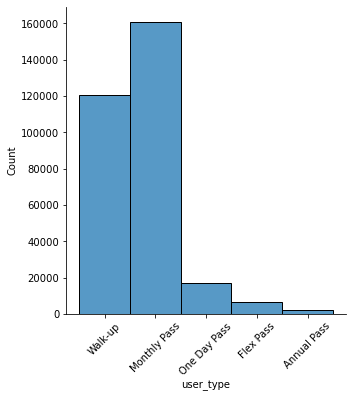

In [17]:
sns.displot(df_LA["user_type"]).set_xticklabels(rotation=45)

Mean of trip duration for different user_types

In [18]:
df_LA.groupby("user_type").mean()["trip_duration_in_hours"]

user_type
Annual Pass     0.177379
Flex Pass       0.234193
Monthly Pass    0.213685
One Day Pass    0.899606
Walk-up         0.703862
Name: trip_duration_in_hours, dtype: float64

Here are the prices that can be found on https://bikeshare.metro.net/ at the moment (actual prices in december 2021). But the same prices seem to partly have been in place also in 2018: https://la.streetsblog.org/2018/05/18/metro-committee-approves-cutting-bike-share-prices-expanding-system/

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>365-Day PAss</td>
    <td>150/year & 1,75 after 30min</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>30-Day Pass </td>
    <td>17/month & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>24-Hour Access</td>
    <td>5/day & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>1.75 per 30min</td>
  </tr>
</table>


These were the prices that can be found on https://thesource.metro.net/2016/06/22/metro-bike-share-what-will-it-cost-and-how-to-use-tap-to-get-a-bike/ (prices of 2016)

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>Flex Pass</td>
    <td>40/year & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>Monthly Pass </td>
    <td>20/month & 1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>3.50 per 30min</td>
  </tr>
</table>

@MYSELF das ergibt glaube ich sinn. Flex PAss war alt und 2016. Das neue Model ist dann mit Monthly Pass.

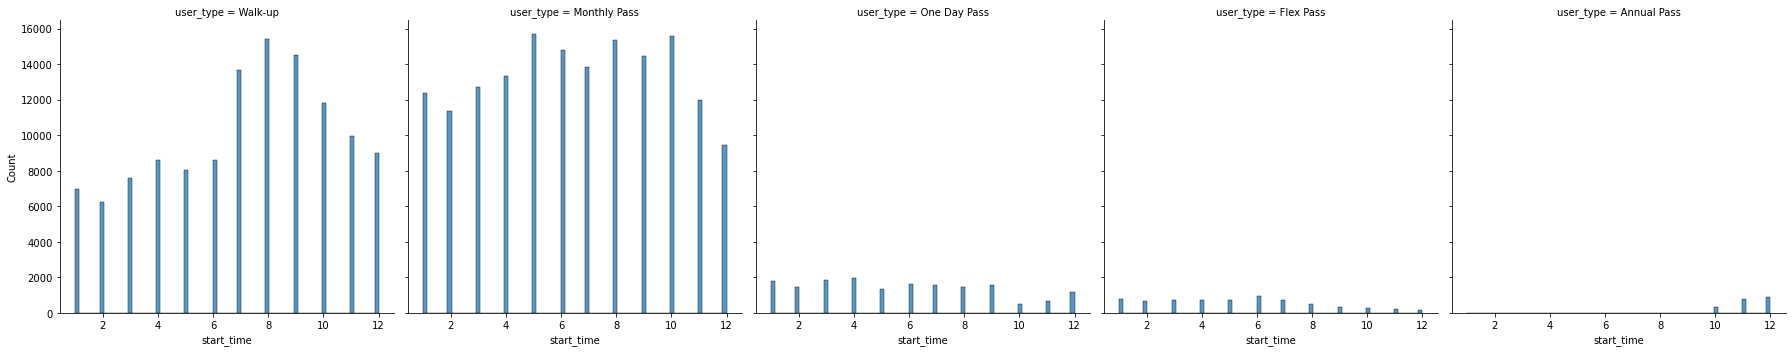

In [20]:
df_temp = df_LA.copy()
df_temp["start_time"] = df_temp["start_time"].dt.month


sns.displot(df_temp, x="start_time", col="user_type")

#sns.displot(df_Annual, x="start_time", hue="user_type", multiple = "stack")


Having a closer look at the Annual Pass, because there were no rides in the first 8 months.

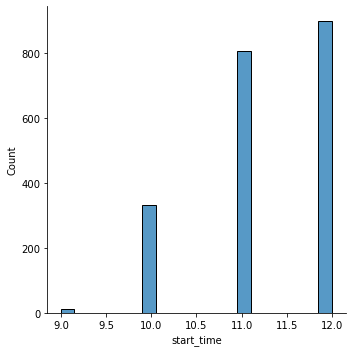

In [22]:
sns.displot(df_temp[df_temp["user_type"] == "Annual Pass"], x="start_time")

In [24]:
df_LA[df_LA["user_type"] == "Annual Pass"]["start_time"].describe(datetime_is_numeric=True)

count                             2049
mean     2018-11-24 10:45:31.039531264
min                2018-09-29 13:52:00
25%                2018-11-08 15:06:00
50%                2018-11-27 09:46:00
75%                2018-12-13 09:05:00
max                2018-12-31 22:46:00
Name: start_time, dtype: object

The first time a ride with the Annual Pass took place was on 2018-09-29. The Annual Pass was introduced in ???